# CV_Instance_Segmentation_0

이정재  
2024-02-13

## Instance Segmentation

#### Detectron2 다운로드

In [2]:
#!pip install git+https://github.com/facebookresearch/fvcore.git
#!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
#!pip install -e detectron2_repo

#### COCO 2017 데이터셋 다운로드

In [3]:
!rm -r coco

rm: cannot remove 'coco': No such file or directory

In [4]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2024-02-13 02:07:06--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.33.73, 16.182.70.25, 52.217.104.196, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.33.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  14.6MB/s    in 21m 15s 

2024-02-13 02:28:21 (14.5 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2024-02-13 02:28:21--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.134.73, 54.231.199.1, 54.231.235.145, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.134.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 77

In [1]:
# Unzip
!unzip -q train2017.zip -d ./coco
!unzip -q val2017.zip -d ./coco
!unzip -q annotations_trainval2017.zip -d ./coco

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader

In [2]:
import torch
# 재현성을 위한 시드넘버 고정
random_seed = 2024
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("coco_train_data",{},'/root/2024winter/DL_tutorial/posts/coco/annotations/instances_val2017.json', '/root/2024winter/DL_tutorial/posts/coco/val2017')
register_coco_instances("coco_val_data",{},'/root/2024winter/DL_tutorial/posts/coco/annotations/instances_val2017.json', '/root/2024winter/DL_tutorial/posts/coco/val2017')

In [3]:
# MetadataCatalog
train_metadata = MetadataCatalog.get("coco_train_data")
val_metadata = MetadataCatalog.get("coco_val_data")
train_metadata

In [4]:
# DatasetCatalog
train_dataset_dicts = DatasetCatalog.get("coco_train_data")
val_dataset_dicts = DatasetCatalog.get("coco_val_data")


[02/13 04:42:15 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /root/2024winter/DL_tutorial/posts/coco/annotations/instances_val2017.json
[02/13 04:42:16 d2.data.datasets.coco]: Loading /root/2024winter/DL_tutorial/posts/coco/annotations/instances_val2017.json takes 1.03 seconds.
[02/13 04:42:17 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /root/2024winter/DL_tutorial/posts/coco/annotations/instances_val2017.json

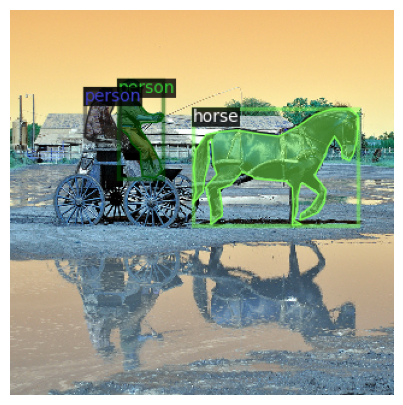

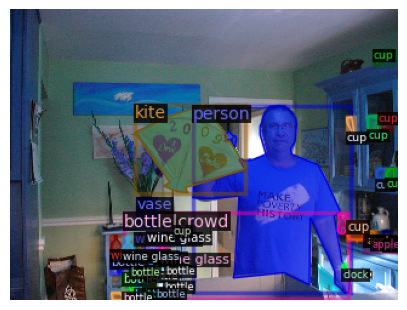

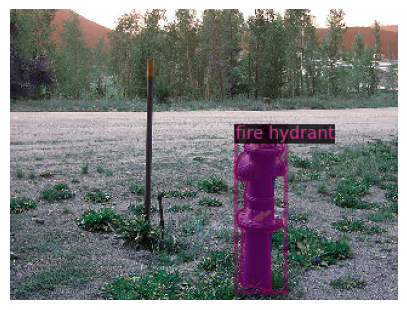

In [5]:


for d in random.sample(train_dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(5, 5))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

In [7]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(
    "./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.DATASETS.TRAIN = ("coco_train_data",)
cfg.DATASETS.TEST = ("coco_val_data",)  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.002
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 80
cfg.OUTPUT_DIR = "/root/2024winter/DL_tutorial/posts/outputs"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/13 04:44:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("coco_val_data", output_dir = "./output")
val_loader = build_detection_test_loader(cfg, "coco_val_data")
inference_on_dataset(trainer.model, val_loader, evaluator)

[02/13 04:51:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /root/2024winter/DL_tutorial/posts/outputs/model_final.pth ...
[02/13 04:51:03 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /root/2024winter/DL_tutorial/posts/coco/annotations/instances_val2017.json
[02/13 04:51:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/13 04:51:04 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/13 04:51:04 d2.data.common]: Serializing 5000 elements to byte tensors and concatenating them all ...
[02/13 04:51:04 d2.data.common]: Serialized dataset takes 19.22 MiB
[02/13 04:51:04 d2.evaluation.evaluator]: Start inference on 5000 batches
[02/13 04:51:05 d2.evaluation.evaluator]: Inference done 11/5000. Dataloading: 0.0014 s/iter. Inference: 0.0588 s/iter. Eval: 0.0347 s/iter. Total: 

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set the testing threshold for this model
cfg.DATASETS.TEST = ("coco_val_data",)
predictor = DefaultPredictor(cfg)

[02/13 05:02:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /root/2024winter/DL_tutorial/posts/outputs/model_final.pth ...

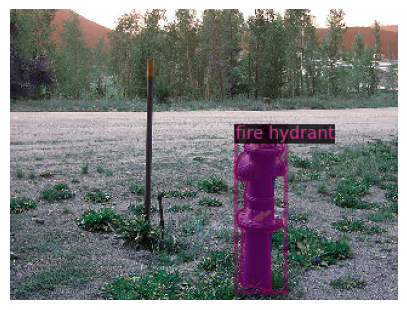

In [12]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                  metadata=val_metadata,
                  scale=0.8,
                  instance_mode=ColorMode.IMAGE_BW) # remove the colors of unsegmented pixels
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(5, 5))
plt.imshow(vis.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

In [14]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [17]:
!unzip /root/2024winter/DL_tutorial/posts/instance_custom_annotation.zip -d /root/2024winter/DL_tutorial/posts/coco

Archive:  /root/2024winter/DL_tutorial/posts/instance_custom_annotation.zip
  inflating: /root/2024winter/DL_tutorial/posts/coco/__MACOSX/._annotations  
  inflating: /root/2024winter/DL_tutorial/posts/coco/annotations/instances_custom.json  
  inflating: /root/2024winter/DL_tutorial/posts/coco/__MACOSX/annotations/._instances_custom.json  

## `코드 추가 작성 예정 . . .`